# Make with database: National Stock Exchange : Time Series
- Link: https://www.kaggle.com/datasets/atulanandjha/national-stock-exchange-time-series

In [4]:
from google.colab import drive
drive.mount('/content/drive')

path_dataset = "/content/drive/MyDrive/Class/nam-4/ky-1/ML/TH2/Dataset/RNN_LSTM"

Mounted at /content/drive


# Importing libraries

In [10]:
import numpy as np
import pandas as pd
import gc
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from IPython.display import clear_output
import time

In [11]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential, Input, initializers, optimizers, callbacks, layers

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from sklearn.model_selection import train_test_split
from keras.layers import SimpleRNN
from keras.layers import GRU
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, BatchNormalization, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D

# Loading data

In [12]:
df = pd.read_csv(path_dataset + "/infy_stock.csv",
                 usecols=['Date', 'Close'], parse_dates=['Date'],index_col='Date')
df.shape

(248, 1)

In [13]:
print("Min:",df.index.min())
print("Max:",df.index.max())

Min: 2015-01-01 00:00:00
Max: 2015-12-31 00:00:00


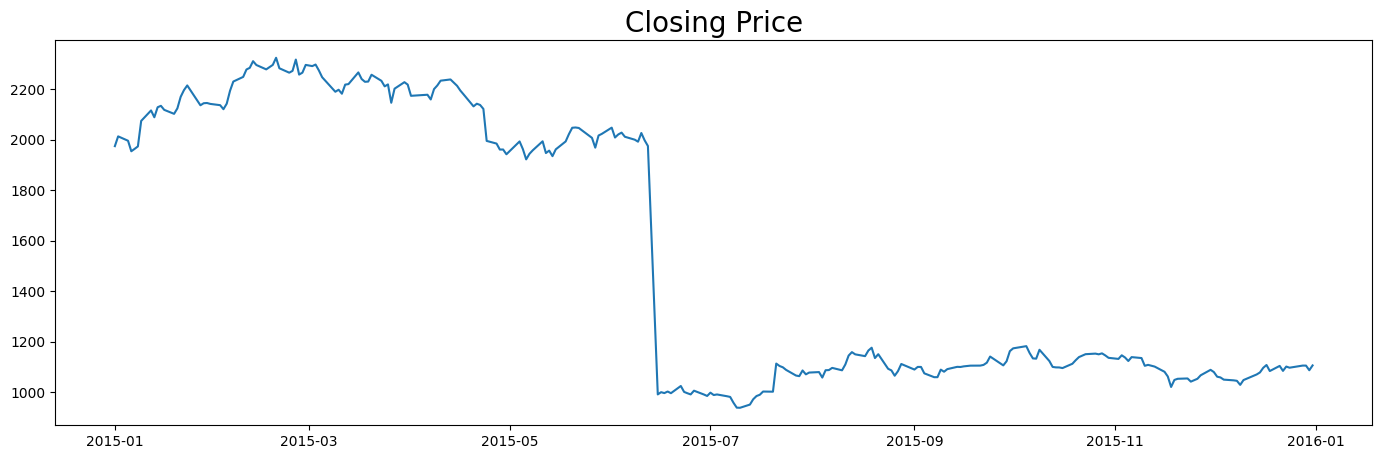

In [14]:
plt.figure(figsize=(17,5))
plt.plot(df['Close'])
plt.title("Closing Price",fontsize=20)
plt.show()

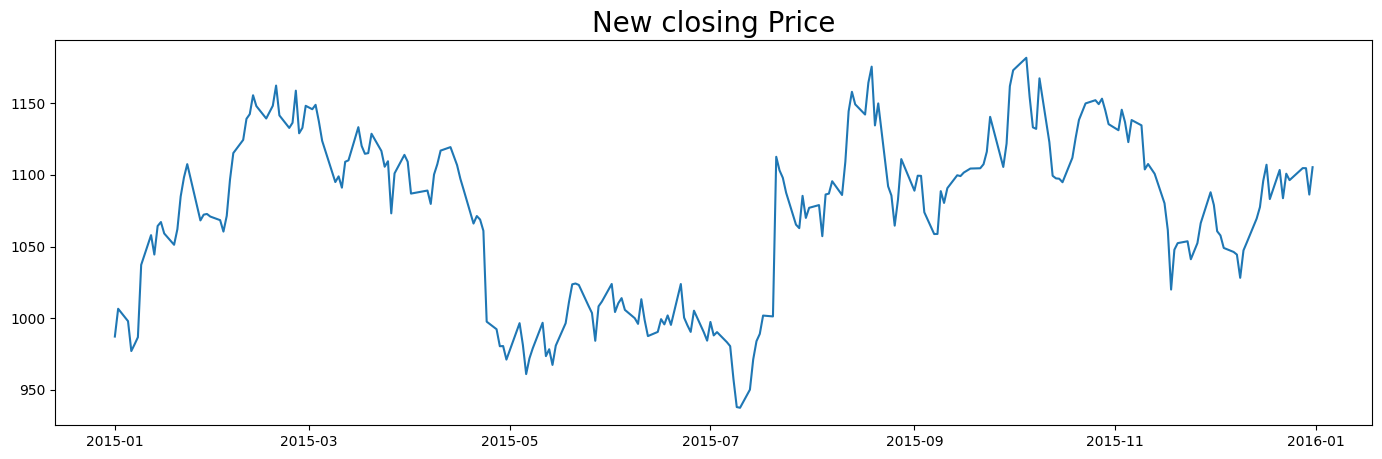

In [15]:
prices = pd.concat([df.Close[:'2015-06-12']/2,df.Close['2015-06-15':]])
plt.figure(figsize=(17,5))
plt.plot(prices)
plt.title("New closing Price",fontsize=20)
plt.show()

# Scalling

In [16]:
scaler = StandardScaler()
prices = scaler.fit_transform(prices.values.reshape(-1, 1)).flatten()
train, test = train_test_split(prices, test_size=0.3, shuffle=False)

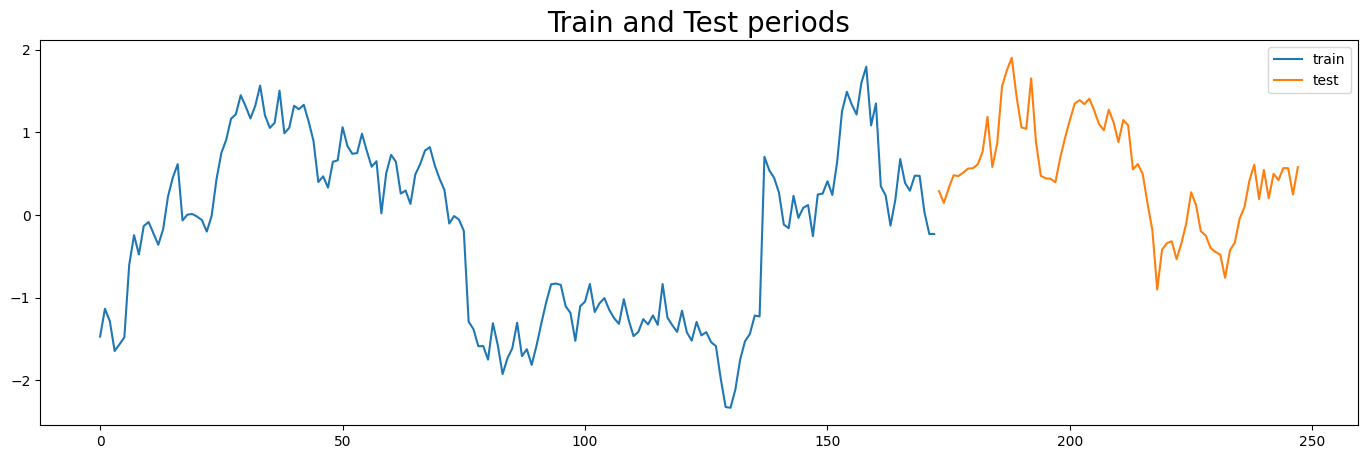

In [17]:
plt.figure(figsize=(17,5))
plt.plot(train, label='train')
plt.plot(np.arange(len(train), len(train)+len(test)), test, label='test')
plt.title("Train and Test periods", fontsize=20)
plt.legend()

In [18]:
def get_chunks(train, n_input, n_out=7):
    X, y = list(), list()
    in_start = 0
    for _ in range(len(train)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end <= len(train):
            x_input = train[in_start:in_end]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(train[in_end:out_end])
            in_start += 1
    return np.array(X),np.array(y)

In [19]:
n_input = 7
X_train, y_train = get_chunks(train, n_input=n_input, n_out=1)
X_test, y_test = get_chunks(test, n_input=n_input, n_out=1)

In [20]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [21]:
fit_params = {
        'x': X_train,
        'y': y_train,
        'validation_data': (X_test, y_test),
        'verbose': 1,
        'epochs': 40,
        'batch_size': 16}

In [22]:
def results_plot(history):

    plt.figure(figsize=(17,5))
    plt.plot(history.history['loss'], color='b', label="train loss")
    plt.plot(history.history['val_loss'], color='r', label="val loss")

    plt.plot()

def plot_preds(y_test, preds):

    plt.figure(figsize=(17,5))
    plt.plot(preds, label='preds')
    plt.plot(y_test, label='test')
    plt.legend()
    plt.title('Real test and predicted')
    plt.show()

In [23]:
def mae(y_true, y_pred):
    output_errors = np.average(np.abs(y_pred - y_true), axis=0)
    return np.average(output_errors)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

def brief_stats(y_true, y_pred):
    print(pd.Series({
        'mape': mape(y_true, y_pred),
        'mae': mae(y_true, y_pred),
        'rmse': rmse(y_true, y_pred),
    }))

# Build model

In [24]:
def lstm1():
    model = Sequential()
    model.add(LSTM(12, activation='relu', input_shape=(1,n_input),
                   return_sequences=True
                  ))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')

    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.6646 - val_loss: 0.6617
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.7154 - val_loss: 0.5756
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5319 - val_loss: 0.4980
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5063 - val_loss: 0.4278
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4729 - val_loss: 0.3673
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3862 - val_loss: 0.3133
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3271 - val_loss: 0.2761
Epoch 8/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3117 - val_loss: 0.2538
Epoch 9/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2751 - val_loss: 0.2401
Epoch 10/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2846 - val_loss: 0.2334
Epoch 11/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3134 - val_loss: 0.2264
Epoch 12/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3377 - val_

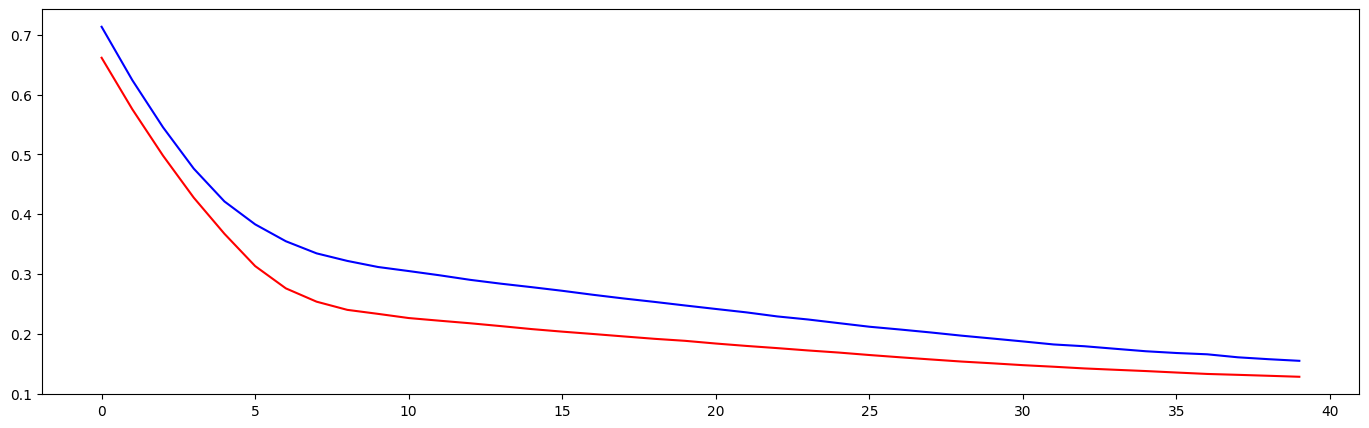

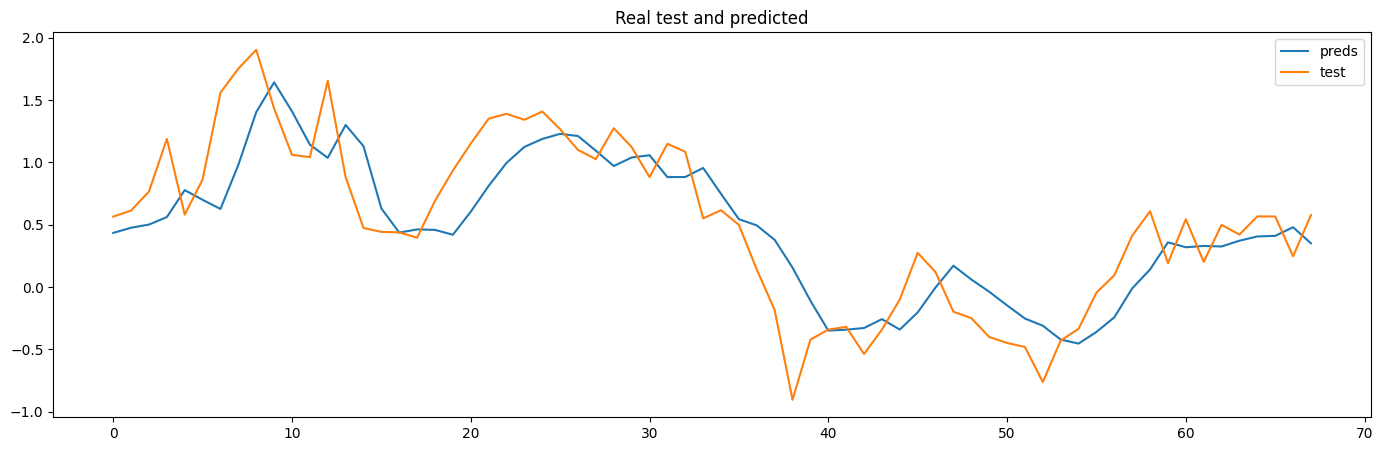

mape    69.602397
mae      0.286653
rmse     0.358105
dtype: float64


In [25]:
lstm_model = lstm1()
history_lstm =  lstm_model.fit(**fit_params)
results_plot(history_lstm)

preds = lstm_model.predict(X_test).flatten()
plot_preds(y_test[:, 0], preds)
brief_stats(y_test[:, 0], preds)

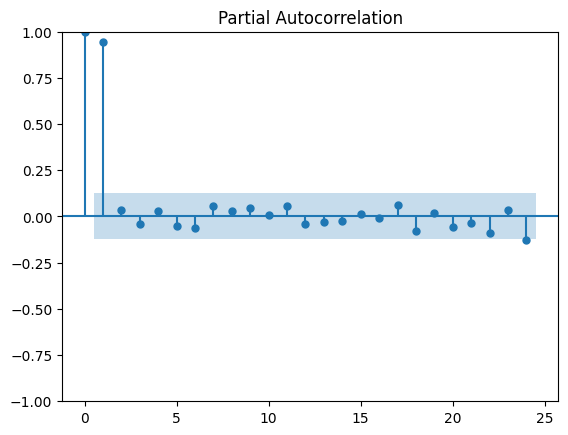

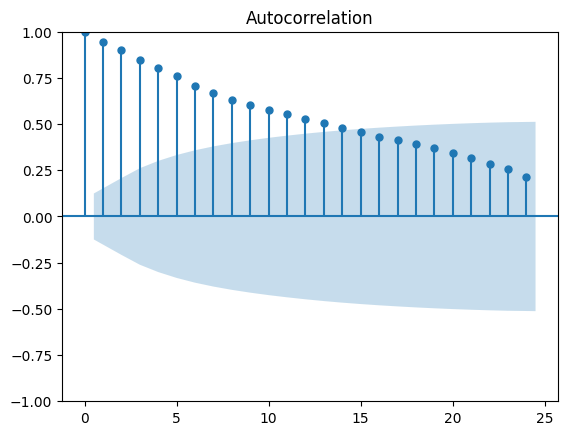

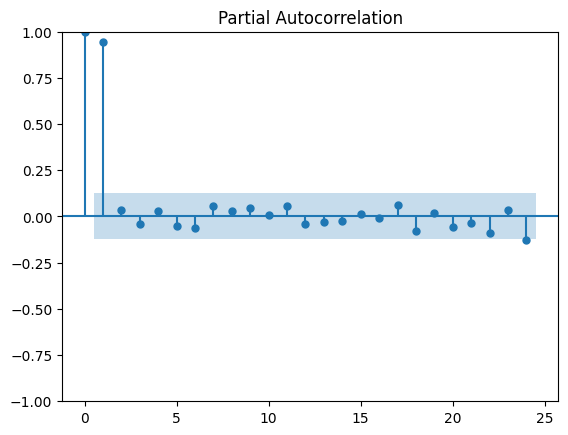

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_acf(prices)
plot_pacf(prices)